<a href="https://colab.research.google.com/github/ZhaishenGForSaken/edge-computer-vision/blob/master/GAN_Leo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# TensorFlow and tf.keras
%tensorflow_version 2.x
import tensorflow as tf

# kears model building blocks
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from IPython import display

In [ ]:
##此处使用opencv作为通道分离，实验后发现貌似不需要分离通道信息
import cv2

In [ ]:
#提取红色通道
def get_red(img):
    redImg = img[:,:,2]
    return redImg

In [ ]:
#提取绿色通道
def get_green(img):
    greenImg = img[:,:,1]
    return greenImg

In [ ]:
#提取蓝色通道
def get_blue(img):
    blueImg = img[:,:,0]
    return blueImg

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat

--2020-06-17 12:30:23--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  16.3MB/s    in 15s     

2020-06-17 12:30:38 (11.5 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]



In [3]:
import scipy.io as scio

path = 'train_32x32.mat'
data = scio.loadmat(path)


In [ ]:
type(data)

dict

In [4]:
X1 = data['X']  
type(X1)

numpy.ndarray

In [5]:
print(X1.shape)
##因此需要进行数组维度变换


(32, 32, 3, 73257)


In [6]:
X1=X1.transpose(3,0,1,2)
print(X1.shape)

(73257, 32, 32, 3)


In [7]:
##增加标准化
X1=X1/255.0

##此处为实例代码，别跑

In [ ]:
mnist = tf.keras.datasets.mnist

(X_train, _), (_, _) = mnist.load_data()
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
# Normalize pixel values to be between 0 and 1
train_images = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
train_images = train_images /255.0 # Normalize the images to [0, 1]
print(train_images.shape)

(60000, 28, 28, 1)


##跑看一下效果

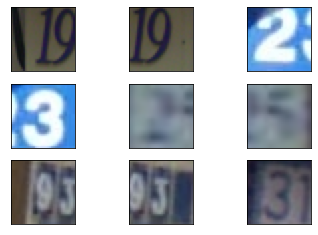

In [10]:
def plot_images(img, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])

# Plot some training set images
plot_images(X1, 3, 3)

In [11]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(X1).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

### The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 32 x 32 x 3. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

(1, 100)
(1, 32, 32, 3)


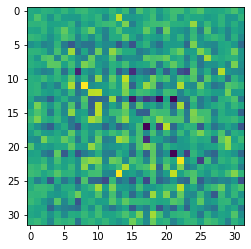

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

print(noise.shape)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator
The discriminator is a CNN-based image classifier.

In [ ]:
###原参数是28*28

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00116535]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers
Define loss functions and optimizers for both models.

In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop

In [20]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 25

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=True)

  fig = plt.figure(figsize=(6,6))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
save_model

NameError: ignored

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
!cd sample_data

###我这边写一下思路吧
###这个作业我一开始以为需要分离通道信息，但是我看完了随机噪声貌似是一个彩色空间中的任意一个点，所以省很多麻烦
###现在看来只需要下载训练集然后看一下效果，然后更改一下生成模型和判断模型就可以
###我明天手里事情忙完之后有空先用老师推荐的命令先把训练集下了跑一下试试
###使用命令!wget下载到drive，但是需要先cd到制定路径
###顺便这边也提一下吧，如果要更改自己的模型的话我需要再阅读一些文档看看28*28和描述的32*32是个什么情况
####                                                           Update on 6/14 23.54